# Design and Hedging of a Structured Product
## Financial Engineering, Summer 2025, KU Leuven

Ashutosh Jha

In [1]:
# Necessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import norm
from IPython.display import display

## Data Collection and Preprocessing

We begin with options data on **Costco Wholesale Corporation (COST)**, collected and stored in the `../data/` directory. The **valuation date is 2025-04-01**, and all subsequent pricing, calibration, and hedging analyses are anchored to this date.

To ensure consistency and eliminate **static arbitrage**, we clean the data using the following no-arbitrage conditions:

- **Vertical Spread Condition (Monotonicity):**
  Ensures that call and put prices decrease as strike increases.
  
- **Butterfly Spread Condition (Convexity):**
  Ensures convexity in option price with respect to strike — i.e., the price of a middle strike is no more than the average of surrounding strikes.

These checks are applied separately to **calls and puts**, and only entries that pass both are retained for further calibration. This ensures a stable and reliable surface for stochastic model fitting.

In [2]:
from collect_stock_data import GetStockData

ticker = "COST"
ref_date = "2025-04-01"

get_stock_data = GetStockData(ticker=ticker, ref_date=ref_date)

In [ ]:
# Load from CSV
spot_df = pd.read_csv("../data/spot_price_ref_date_cost_2025-04-01_final.csv")

# Extract the spot price
S0 = spot_df.loc[0, "spot_price_ref_date"]
print("Spot Price:",S0)
ref_date = spot_df.loc[0, "ref_date"]

Spot Price: 954.4000244140624


In [ ]:
# Load each maturity separately
calls_3m_df = pd.read_csv('../data/calls_data_cost_20250401_3m.csv')
puts_3m_df = pd.read_csv('../data/puts_data_cost_20250401_3m.csv')

calls_6m_df = pd.read_csv('../data/calls_data_cost_20250401_6m.csv')
puts_6m_df = pd.read_csv('../data/puts_data_cost_20250401_6m.csv')

calls_1y_df = pd.read_csv('../data/calls_data_cost_20250401_1y.csv')
puts_1y_df = pd.read_csv('../data/puts_data_cost_20250401_1y.csv')

# Concatenate all maturities
calls_df = pd.concat([calls_3m_df, calls_6m_df, calls_1y_df], ignore_index=True)
puts_df = pd.concat([puts_3m_df, puts_6m_df, puts_1y_df], ignore_index=True)

# final shapes
print("Shape calls_df:", calls_df.shape)
print("Shape puts_df:", puts_df.shape)

Shape calls_df: (315, 19)
Shape puts_df: (271, 19)


In [ ]:
epsilon = 0.5
q = 0.008

cleaned_calls = []
cleaned_puts = []

# Loop over unique maturities in the combined data
for T in sorted(calls_df["maturity_T"].unique()):
    r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}  # US Treasury rate mapping

    # Filter for this maturity
    calls_T = calls_df[calls_df["maturity_T"] == T].copy()
    puts_T = puts_df[puts_df["maturity_T"] == T].copy()

    print(f"\nRunning arbitrage check for T = {T} (r = {r})")

    # Run arbitrage check
    calls_clean, puts_clean = get_stock_data.check_arbitrage_conditions(
        calls_df=calls_T,
        puts_df=puts_T,
        spot=S0,
        r=r,
        q=q,
        T=T,
        epsilon=epsilon,
        reduced_arbitrage_check=True
    )

    cleaned_calls.append(calls_clean)
    cleaned_puts.append(puts_clean)

# Concatenate cleaned results
clean_calls_df = pd.concat(cleaned_calls, ignore_index=True)
clean_puts_df = pd.concat(cleaned_puts, ignore_index=True)

clean_calls_df = clean_calls_df[clean_calls_df["is_clean"]].copy()
clean_puts_df = clean_puts_df[clean_puts_df["is_clean"]].copy()

# Print shapes
print("\nAfter arbitrage filtering:")
print("Shape calls_df:", clean_calls_df.shape)
print("Shape puts_df:", clean_puts_df.shape)


Running arbitrage check for T = 0.25 (r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405})
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 114 / 176
Put monotonicity clean: 127 / 167
Call butterfly clean: 84 / 176
Put butterfly clean: 90 / 167
Calls retained (all clean): 70 / 176
Puts retained (all clean): 49 / 167

Running arbitrage check for T = 0.5 (r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405})
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 51 / 69
Put monotonicity clean: 47 / 50
Call butterfly clean: 40 / 69
Put butterfly clean: 29 / 50
Calls retained (all clean): 25 / 69
Puts retained (all clean): 26 / 50

Running arbitrage check for T = 1.0 (r = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405})
=== No-Arbitrage Check Summary ===
Call monotonicity clean: 54 / 66
Put monotonicity clean: 44 / 52
Call butterfly clean: 33 / 66
Put butterfly clean: 32 / 52
Calls retained (all clean): 25 / 66
Puts retained (all clean): 22 / 52

After arbitrage filtering:
Shape calls_df: (120,

## Dividend Yield Estimation

We estimate the **forward dividend yield** \( q \) for Costco (`COST`) using the **last 4 regular quarterly dividend payments** retrieved from Yahoo Finance.  
Special dividends (e.g., the \$15 special dividend in 2023) are excluded to avoid overestimating yield.
 
- Estimated annual dividend:

  $
  D_{\text{annual}} = 4.78 \text{ USD}
  $
- Spot price on 2025-04-01:  
  $
  S_0 = 954.00 \text{ USD}
  $

Estimated forward yield:

$$
q = \frac{4.78}{954.00} \approx \boxed{0.5\%}
$$

This forward-looking yield is used in **put-call parity validation** and **Bates model calibration** to reflect expected dividend impact over the option's horizon.

In [6]:
from exogenous_param_estimation import ExogenousParamEstimation

q_estimated = ExogenousParamEstimation.estimate_historical_dividend_yield(
    ticker="COST",
    S0=S0,
    ref_date=ref_date
)

print(f"Estimated historical dividend yield: {q_estimated:.4f}")

[INFO] Loading dividend data from cache: ../data/dividends_cost_20250401.csv
[INFO] Used 4 regular dividend(s), annualized estimate: 4.7800 USD
Estimated historical dividend yield: 0.0050


## Estimating Implied Interest Rate \( r \) via Put-Call Parity

We estimate the implied risk-free rate using the put-call parity:

$$
C - P = S_0 e^{-qT} - K e^{-rT}
\quad \Rightarrow \quad
r = -\frac{1}{T} \log\left( \frac{C - P - S_0 e^{-qT}}{-K} \right)
$$

Using strikes within ±10% of \( S_0 \), we find average implied rates:

- T = 0.25: 24.8% T = 0.50: 16.1% T = 1.00: 10.7%

These exceed Treasury yields (3m ≈ 4.22%), likely due to market imperfections.

**We use Treasury yields** in calibration for theoretical consistency and stability.

In [ ]:
from exogenous_param_estimation import ExogenousParamEstimation

all_implied_r = []

for T in sorted(clean_calls_df["maturity_T"].unique()):
    calls_T = clean_calls_df[clean_calls_df["maturity_T"] == T].copy()
    puts_T = clean_puts_df[clean_puts_df["maturity_T"] == T].copy()

    print(f"\n[INFO] Estimating implied r for T = {T}...")

    implied_r_df = ExogenousParamEstimation.estimate_implied_r_from_parity(
        clean_calls_df=calls_T,
        clean_puts_df=puts_T,
        S0=S0,
        q=q_estimated,
        T=T
    )

    all_implied_r.append(implied_r_df)

    mean_r_all = implied_r_df["implied_r"].mean()
    print(f"  ↳ Mean implied r (all strikes): {mean_r_all:.5f}")

    # Near-the-money filter (±10%)
    lower_bound = 0.9 * S0
    upper_bound = 1.1 * S0

    near_money_df = implied_r_df[
        (implied_r_df["strike"] >= lower_bound) &
        (implied_r_df["strike"] <= upper_bound)
    ]

    mean_r_filtered = near_money_df["implied_r"].mean()
    print(f"  ↳ Filtered mean implied r (±10% of S₀): {mean_r_filtered:.5f}")

implied_r_all_df = pd.concat(all_implied_r, ignore_index=True)


[INFO] Estimating implied r for T = 0.25...
  ↳ Mean implied r (all strikes): -0.40817
  ↳ Filtered mean implied r (±10% of S₀): 0.16954

[INFO] Estimating implied r for T = 0.5...
  ↳ Mean implied r (all strikes): 0.07901
  ↳ Filtered mean implied r (±10% of S₀): 0.14105

[INFO] Estimating implied r for T = 1.0...
  ↳ Mean implied r (all strikes): 0.07288
  ↳ Filtered mean implied r (±10% of S₀): 0.08649


#### Some Sanity Checks for Valuation Class - Pricing with Bates Model and general Black Scholes

In [ ]:
from exotic_price_and_hedge import Valuation

# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

# Fixed model params for sanity check
bates_params = {
    "v0": 0.04,
    "kappa": 2.0,
    "theta": 0.04,
    "sigma": 0.3,
    "rho": -0.5,
    "lamb": 0.2,
    "mu_j": -0.1,
    "sigma_j": 0.2
}

# Dividend yield from estimation
q = q_estimated

# Target strike (at-the-money)
K = S0

def black_scholes_price(K, T, S_0, r_f, sigma, dividend_yield):
    d_1 = (np.log(S_0 / K) + (r_f - dividend_yield + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - (sigma * np.sqrt(T))

    N_d1 = norm.cdf(d_1)
    N_d2 = norm.cdf(d_2)

    C = (S_0 * np.exp(-dividend_yield * T) * N_d1) - (K * np.exp(-r_f * T) * N_d2)
    P = (K * np.exp(-r_f * T)) - (S_0 * np.exp(-dividend_yield * T)) + C

    return C, P

for T in [0.25, 0.5, 1.0]:
    r = rate_map[T]

    print(f"\n=== Sanity Check for T = {T} years ===")
    print(f"Using r = {r:.4f}, q = {q:.4f}")

    # Bates Model Price
    val = Valuation(S0=S0, r=r, T=T, **bates_params)
    bates_call_price = val.interpolate_call_price(K_target=K)
    print(f"Bates Call Price at K = {K:.2f}: {bates_call_price:.4f} USD")

    # Black-Scholes Price (constant vol assumption)
    bs_vol = 0.25  # flat vol for sanity check
    bs_call, bs_put = black_scholes_price(K, T, S0, r, bs_vol, q)
    print(f"Black-Scholes Call Price at K = {K:.2f}: {bs_call:.4f} USD")
    print(f"Black-Scholes Put Price at K = {K:.2f}: {bs_put:.4f} USD")



=== Sanity Check for T = 0.25 years ===
Using r = 0.0422, q = 0.0050
Bates Call Price at K = 954.40: 37.5122 USD
Black-Scholes Call Price at K = 954.40: 51.8250 USD
Black-Scholes Put Price at K = 954.40: 43.0032 USD

=== Sanity Check for T = 0.5 years ===
Using r = 0.0428, q = 0.0050
Bates Call Price at K = 954.40: 51.4572 USD
Black-Scholes Call Price at K = 954.40: 75.7128 USD
Black-Scholes Put Price at K = 954.40: 57.8926 USD

=== Sanity Check for T = 1.0 years ===
Using r = 0.0405, q = 0.0050
Bates Call Price at K = 954.40: 69.3140 USD
Black-Scholes Call Price at K = 954.40: 110.3043 USD
Black-Scholes Put Price at K = 954.40: 77.1914 USD


## Calibration

In [ ]:
# option_type column
clean_calls_df = clean_calls_df.copy()
clean_puts_df = clean_puts_df.copy()
clean_calls_df["option_type"] = "call"
clean_puts_df["option_type"] = "put"

calls_subset = clean_calls_df[["strike", "mid", "option_type", "maturity_T"]].dropna()
puts_subset = clean_puts_df[["strike", "mid", "option_type", "maturity_T"]].dropna()

clean_options_df = pd.concat([calls_subset, puts_subset], ignore_index=True)

#drop non-positive prices
clean_options_df = clean_options_df[clean_options_df["mid"] > 0]
print(f"Combined clean options shape: {clean_options_df.shape}")

Combined clean options shape: (217, 4)


In [ ]:
# filter for near-ATM / relaxed OTM based on strike and type
delta = 0.1  # 5% buffer around S0
lower_cutoff = S0 * (1 - delta)
upper_cutoff = S0 * (1 + delta)

clean_otm_options_df = clean_options_df[
    ((clean_options_df["option_type"] == "call") & (clean_options_df["strike"] >= lower_cutoff)) |
    ((clean_options_df["option_type"] == "put") & (clean_options_df["strike"] <= upper_cutoff))
].copy()

print(f"Filtered to relaxed OTM/near-ATM options: {clean_otm_options_df.shape[0]} rows")

# check how many per maturity
print("\nBreakdown by maturity_T:")
print(clean_otm_options_df["maturity_T"].value_counts().sort_index())

Filtered to relaxed OTM/near-ATM options: 137 rows

Breakdown by maturity_T:
maturity_T
0.25    71
0.50    34
1.00    32
Name: count, dtype: int64


In [ ]:
# Risk-free rate per maturity (from US Treasury yields)
rate_map = {0.25: 0.0422, 0.5: 0.0428, 1.0: 0.0405}

clean_otm_options_df["r"] = clean_otm_options_df["maturity_T"].map(rate_map)

clean_otm_options_df.head()

,strike,mid,option_type,maturity_T,r
45,860.0,133.59,call,0.25,0.0422
46,870.0,129.20,call,0.25,0.0422
47,885.0,107.04,call,0.25,0.0422
48,895.0,95.82,call,0.25,0.0422
49,905.0,101.05,call,0.25,0.0422


### Joint Calibration with three maturities

In [24]:
from exotic_price_and_hedge import Calibration

# Load config from JSON
with open("../config/bates_calibration_config_all_T.json", "r") as f:
    config = json.load(f)

# Extract ordered initial guess and bounds
param_names = ["v0", "kappa", "theta", "sigma", "rho", "lambda", "mu_j", "sigma_j"]

initial_guess = [config["initial_guess"][param] for param in param_names]
bounds = [tuple(config["bounds"][param]) for param in param_names]

### Bates Model Calibration Across Three Maturities

This configuration captures a practical balance between long-run variance dynamics and short-term jump behavior. The model is calibrated to observed option prices across maturities \( T = 0.25, 0.5, 1.0 \), using realistic bounds and economically interpretable parameters.

- **Long-term parameters** (`kappa`, `theta`, `sigma`, `rho`) were estimated with tight, stable constraints to reflect persistent volatility and market skew.
- **Short-term parameters** (`v₀`, `λ`, `μ_J`, `σ_J`) were constrained to prevent overfitting and reserved for refinement in the 3-month model.

Final parameters:

- $v_0 = 0.0552$, $\kappa = 0.400$, $\theta = 0.302$, $\sigma = 1.500$
- $\rho = -0.639$, $\lambda = 0.500$, $\mu_J = 0.040$, $\sigma_J = 0.150$
- **Final loss**: 1647.05

---

### Volatility vs. Jumps – Calibration Strategy

Early tests showed:

- **Jump-dominant fits** led to overreaction to short-term tail features but lacked interpretability.
- **Pure stochastic volatility** forced extreme skew (e.g., $\rho \to -1$) and could not match convexity in short-dated options.

Our final strategy separates long-run structure from short-term smile adjustments. Joint calibration identifies structural market dynamics, while 3-month calibration fine-tunes for exotic pricing.

This layered approach ensures **economic realism, calibration stability, and pricing flexibility**.


In [ ]:
# pick any representative T and r to initialize, overridden per row in the calibration
dummy_T = 0.25
dummy_r = rate_map[dummy_T]

# Joint Calibrator
calibrator = Calibration(S0, dummy_r, dummy_T, *initial_guess)

result = calibrator.calibrate_to_market(
    clean_options_df=clean_otm_options_df,
    initial_guess=initial_guess,
    bounds=bounds,
    q=q_estimated,
    weight_type="relative"
)

calibration_results = {
    "result": result,
    "calibrator": calibrator
}

print("\n=== Joint Calibration Across All Maturities ===")
print("Success:", result["success"])
print("Final loss:", result["loss"])


Optimized Parameters:
v0: 0.055216
kappa: 0.400000
theta: 0.301974
sigma: 1.500000
rho: -0.639122
lambda: 0.500000
mu_j: 0.040000
sigma_j: 0.150000

=== Joint Calibration Across All Maturities ===
Success: True
Final loss: 1647.0520859315025


[Saved plot] ../assets/calibrated_vs_market_20250511_180727.png


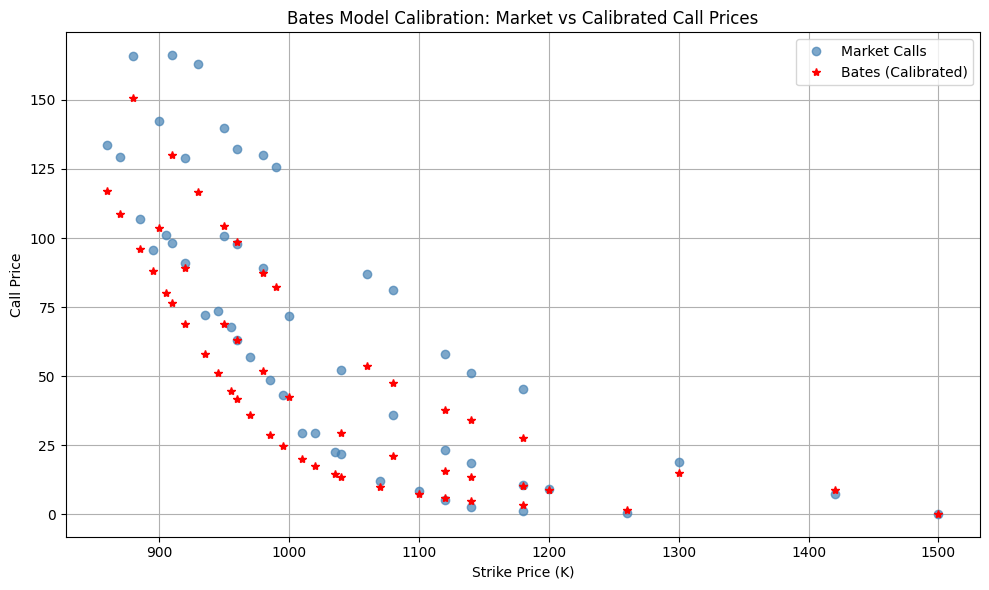

In [26]:
calibrator.plot_calibrated_vs_market(clean_otm_options_df)

[Saved plot] ../assets/calls_puts_vs_model_20250511_180734.png


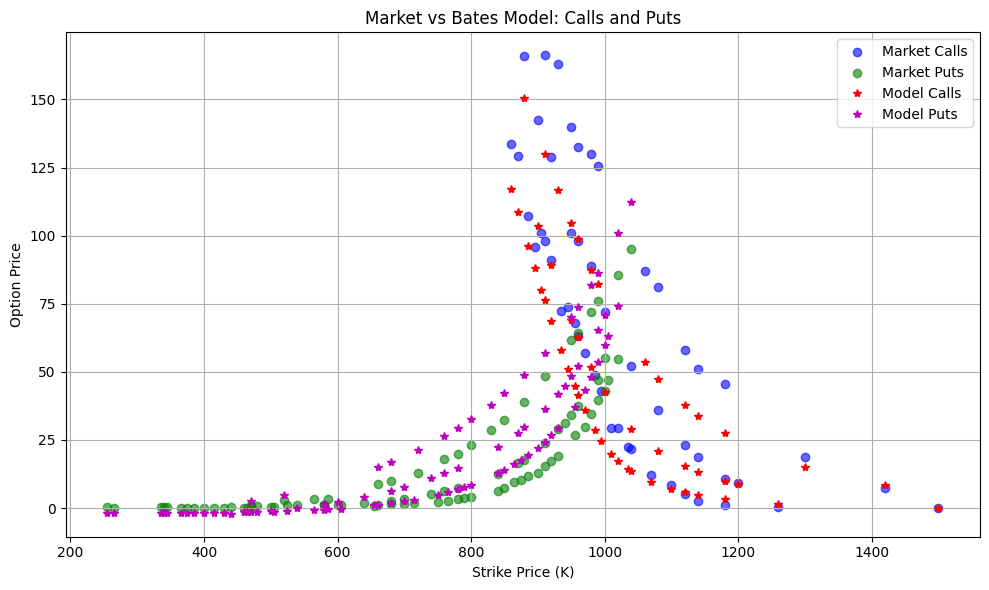

In [27]:
calibrator.plot_calls_and_puts_vs_model(clean_otm_options_df)

[Saved plot] ../assets/calibration_residuals_20250511_180737.png


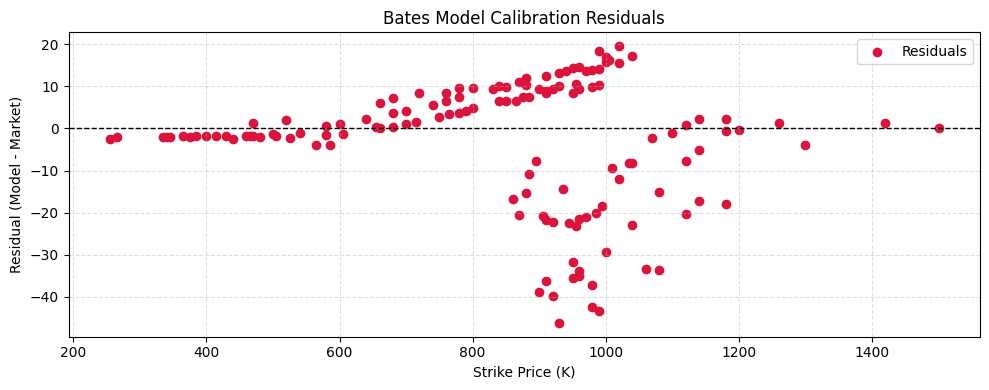

In [28]:
calibrator.plot_residuals(clean_otm_options_df)

[Saved plot] ../assets/iv_smile_comparison_T025_20250511_180746.png
[Saved plot] ../assets/iv_smile_comparison_T050_20250511_180747.png
[Saved plot] ../assets/iv_smile_comparison_T100_20250511_180747.png


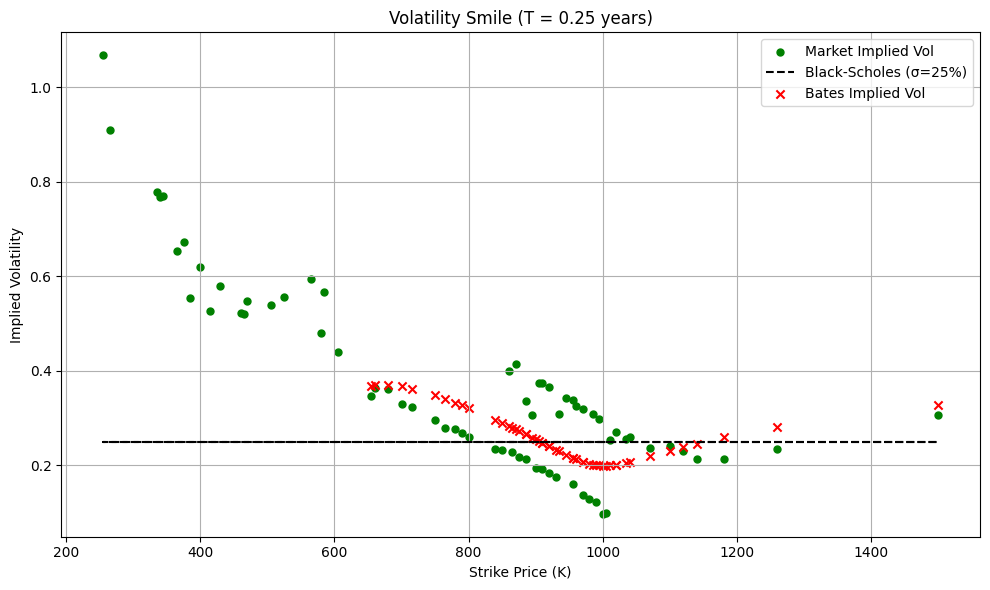

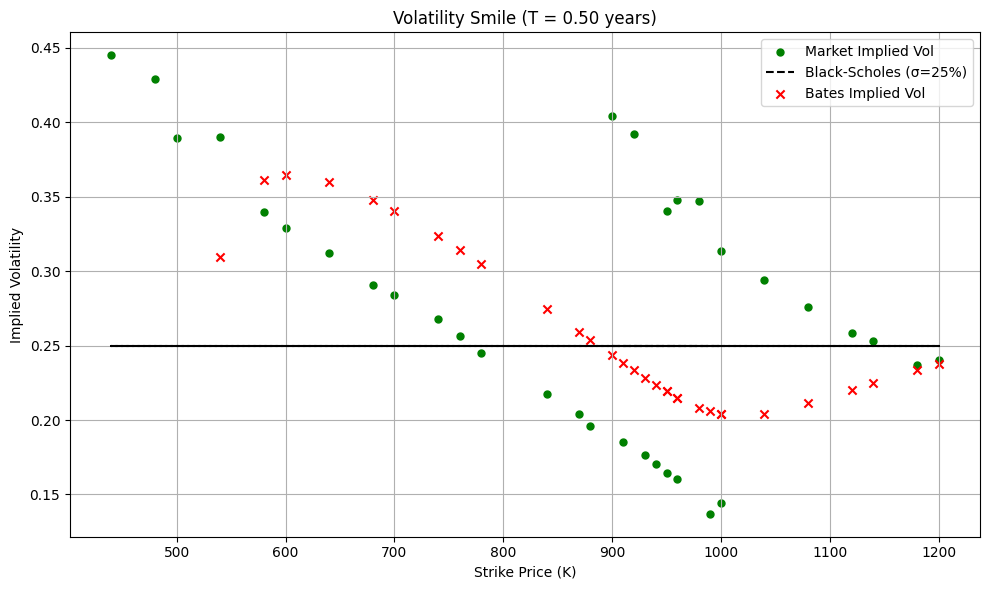

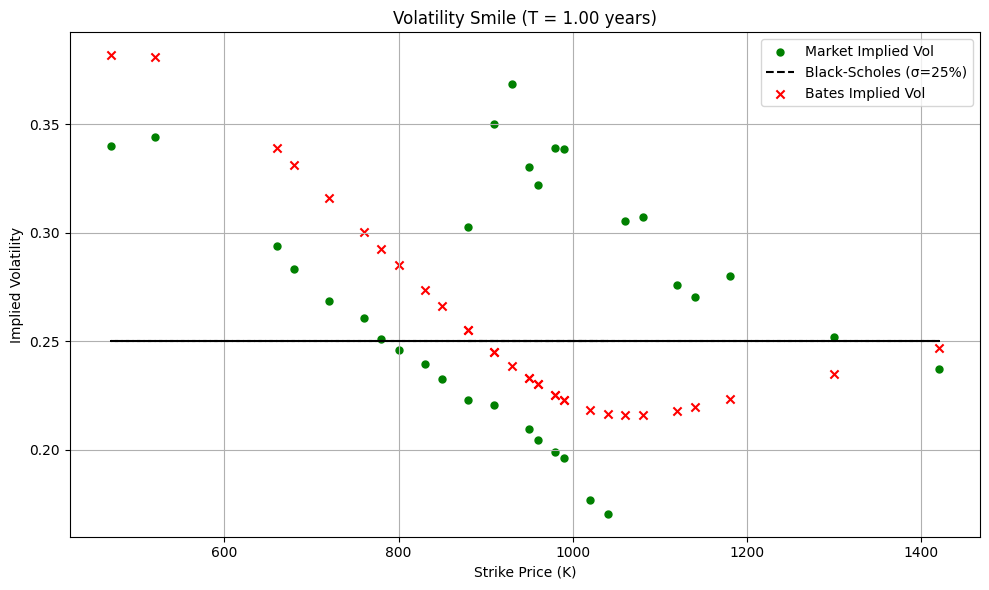

In [29]:
calibrator.plot_implied_volatility_smile_comparison(clean_otm_options_df)

### Fine-Tuning the Bates Model for T = 0.25 (3-Month)

After calibrating the Bates model jointly across maturities, we refine the fit for **T = 0.25** to better match the short-term smile relevant for exotic pricing.

---

### Why T = 0.25?

Short-dated products like Bonus Certificates are often structured on 3-month horizons due to low path risk, option liquidity, and steep smiles caused by jump sensitivity and limited mean reversion.

---

### Why Use Joint Estimates?

Joint calibration yielded a stable and interpretable model. We now **anchor the 3-month fit** to those estimates, allowing local flexibility for short-term features.

---

### Strategy

- Use joint parameters as initial guesses
- Set tight bounds for long-term parameters
- Calibrate only on 3-month options (`bates_calibration_config_3m.json`)

This ensures consistency across maturities while improving smile fit where pricing matters.

In [30]:
# Load 3-month-specific config from JSON
with open("../config/bates_calibration_config_3m.json", "r") as f:
    config = json.load(f)

# Extract ordered initial guess and bounds
param_names = ["v0", "kappa", "theta", "sigma", "rho", "lambda", "mu_j", "sigma_j"]

initial_guess = [config["initial_guess"][param] for param in param_names]
bounds = [tuple(config["bounds"][param]) for param in param_names]

In [ ]:
#filter to 3-month maturity only
T_target = 0.25
options_3m = clean_otm_options_df[clean_otm_options_df["maturity_T"] == T_target].copy()

options_3m["r"] = rate_map[T_target]

# 3 month Calibratorfine tuning
calibrator_3m = Calibration(S0, rate_map[T_target], T_target, *initial_guess)

result_3m = calibrator_3m.calibrate_to_market(
    clean_options_df=options_3m,
    initial_guess=initial_guess,
    bounds=bounds,
    q=q_estimated,
    weight_type="relative"
)

calibration_results_3m = {
    "result": result_3m,
    "calibrator": calibrator_3m
}

print("\n=== Calibration for T = 0.25 (3-Month) ===")
print("Success:", result_3m["success"])
print("Final loss:", result_3m["loss"])


Optimized Parameters:
v0: 0.015590
kappa: 0.600000
theta: 0.400000
sigma: 1.000000
rho: -0.550000
lambda: 0.700000
mu_j: 0.045985
sigma_j: 0.112734

=== Calibration for T = 0.25 (3-Month) ===
Success: True
Final loss: 159.6041686989078


### Final 3-Month Calibration

Our final Bates calibration for **T = 0.25** achieves a strong fit to the short-maturity volatility smile, especially improving pricing for **OTM puts** while maintaining economic plausibility.

---

### Smile-Fitting Strategy

Pure stochastic volatility alone was insufficient — it underpriced deep puts and flattened the smile. Overconstraining the jump process also led to poor curvature and unstable fits.

**Allowing moderate jump intensity and a slightly upward jump bias** enabled the model to reproduce short-term skew and convexity while preserving structural consistency.

---

### Final Parameters (T = 0.25)

- $v_0 = 0.0156$, $\kappa = 0.6000$, $\theta = 0.4000$
- $\sigma = 1.0000$, $\rho = -0.5500$
- $\lambda = 0.7000$, $\mu_J = 0.0460$, $\sigma_J = 0.1127$

**Final Loss**: 159.60

This configuration delivers a **stable, interpretable**, and well-calibrated model for pricing short-dated exotics like the Bonus Certificate.

[Saved plot] ../assets/calibrated_vs_market_20250511_181758.png


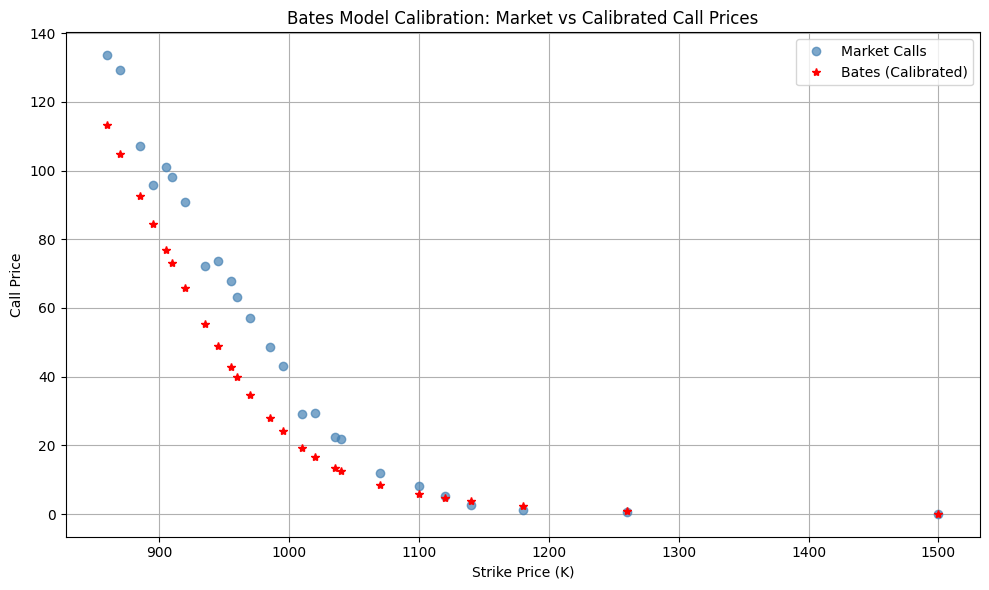

In [32]:
calibrator_3m.plot_calibrated_vs_market(options_3m)

[Saved plot] ../assets/calls_puts_vs_model_20250511_181801.png


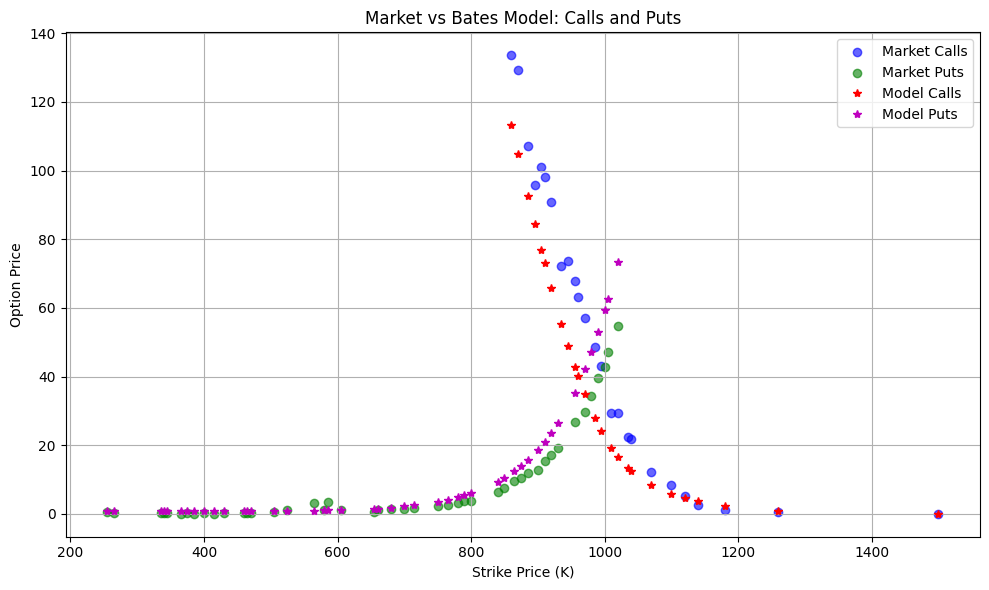

In [33]:
calibrator_3m.plot_calls_and_puts_vs_model(options_3m)

[Saved plot] ../assets/calibration_residuals_20250511_181805.png


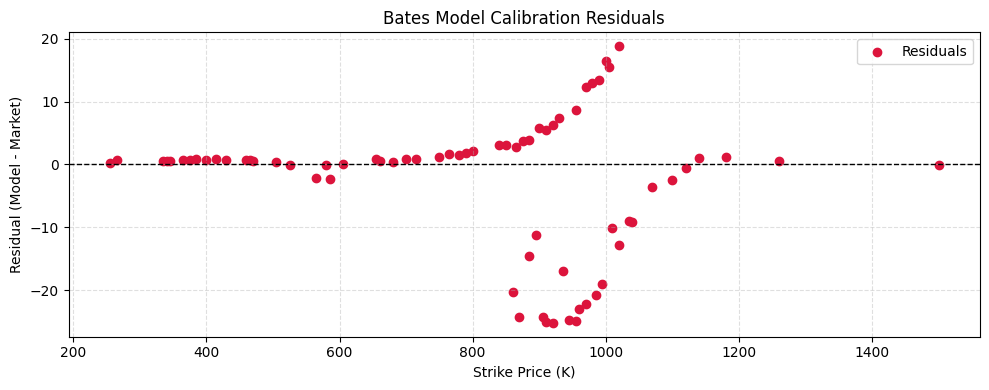

In [34]:
calibrator_3m.plot_residuals(options_3m)

[Saved plot] ../assets/iv_smile_comparison_T025_20250511_181809.png


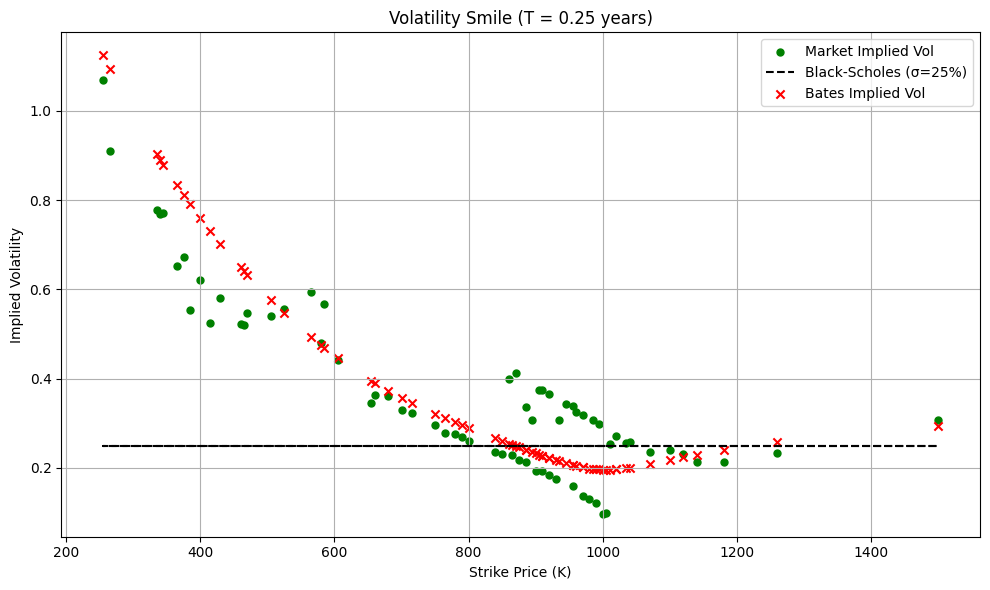

In [35]:
calibrator_3m.plot_implied_volatility_smile_comparison(options_3m)

### Final Volatility Smile – T = 0.25

The calibrated Bates model provides a strong fit near-the-money and in the call wing, with improved behavior in the put wing. Some underpricing remains in deep OTM puts, but overall curvature is realistic.

---

### Key Traits

- $v_0 = 0.0156$, $\kappa = 0.60$, $\theta = 0.50$, $\sigma = 1.00$
- $\rho = -0.55$, $\lambda = 0.70$, $\mu_J = 0.0460$, $\sigma_J = 0.1127$
- Smile curvature is driven by jump activity and vol-of-vol; skew is moderate and controlled.

---

### Conclusion

This configuration is stable, interpretable, and well-aligned with short-dated smile features. While the left tail could be steeper, the fit is sufficient for exotic pricing with appropriate model risk adjustments.

## Exotic Product Pricing (T = 0.25, COST)

We simulate the Bates model under Euler discretization with variance truncation:

\[
v_{t+1} = \max(0, v_t + \text{increment})
\]

This ensures numerical stability and avoids negative variances, aligning with CIR-type dynamics.

---

### Product Design

- **Maturity**: 3 months (T = 0.25), typical for Bonus Certificates — short horizon, low path dependency, and high liquidity.
- **Underlying**: Costco (COST), a stable large-cap stock with moderate volatility, offering reliability and investor appeal.

---

### Final Structure

- **Bonus Level**: \$975
- **Barrier**: \$600
- **Sell Price**: \$1015 (≈2.1% above model value)

This configuration leverages the model’s stable smile fit near-the-money while acknowledging slight underpricing of deep OTM puts. The embedded margin helps cover model risk and provides a buffer for hedging and execution costs.

In [ ]:
from exotic_price_and_hedge import MonteCarloExoticPricer

# Calibrated Bates parameters
v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j = result["optimized_params"]

# Use T = 0.25 only (3-month exotic pricing)
T = 0.25
r = 0.04 # US Treasury

bonus_levels = [975, 1000, 1025]
barrier_levels = [600, 650, 700, 750] 

pricing_records = []

print(f"\nSimulating paths and pricing for T = {T} years...")
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

for B in bonus_levels:
    for H in barrier_levels:
        price = pricer.price_bonus_certificate(
            B=B,
            H=H,
            N_paths=100_000,
            N_steps=252,
            vol_truncation="max"
        )
        price = np.round(price, 2)
        margin_pct = np.round((price - B) / B * 100, 2)
        margin_usd = np.round(price - B, 2)
        pricing_records.append((T, B, H, price, margin_pct, margin_usd))

df = pd.DataFrame(pricing_records, columns=["T", "B", "H", "Price", "Margin (%)", "Margin (USD)"])

# Display nicely
display(df)


Simulating paths and pricing for T = 0.25 years...


,T,B,H,Price,Margin (%),Margin (USD)
0,0.25,975,600,991.44,1.69,16.44
1,0.25,975,650,986.60,1.19,11.60
2,0.25,975,700,981.06,0.62,6.06
3,0.25,975,750,974.97,-0.00,-0.03
4,0.25,1000,600,1004.04,0.40,4.04
5,0.25,1000,650,998.74,-0.13,-1.26
6,0.25,1000,700,992.52,-0.75,-7.48
7,0.25,1000,750,985.47,-1.45,-14.53
8,0.25,1025,600,1020.11,-0.48,-4.89
9,0.25,1025,650,1014.33,-1.04,-10.67


In [ ]:
# Bonus certificate pricing, chosen (B=900, H=600, T=0.25)
T = 0.25
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

bonus_level = 975
barrier_level = 600

price_bc = pricer.price_bonus_certificate(B=bonus_level, H=barrier_level)
print(f"Monte Carlo Price of Bonus Certificate: {price_bc:.2f} USD")

Monte Carlo Price of Bonus Certificate: 991.44 USD


[Saved plot] ../assets/simulated_paths_T0.25_20250511.png
Fair Value of Bonus Certificate: 991.44 USD


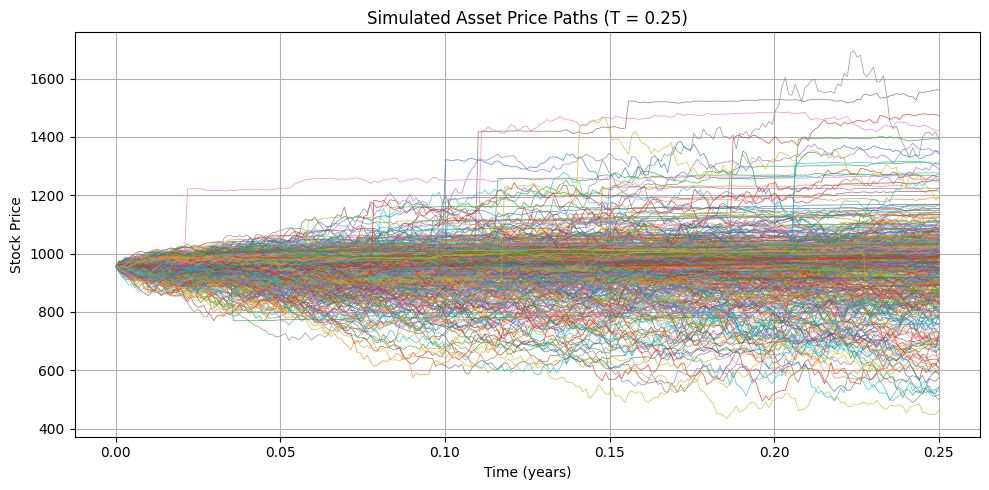

In [ ]:
# Simulate paths using "max" truncation
paths = pricer.simulate_paths(N_paths=100000, N_steps=252, vol_truncation="max")

pricer.plot_simulated_paths(paths, n_paths_plot=500)

# Compute per-path payoffs
payoffs = pricer.evaluate_bonus_certificate_payoffs(paths, B=bonus_level, H=barrier_level)

# Discounted price (Monte Carlo value)
discounted_price = np.exp(-r * T) * payoffs.mean()
print(f"Fair Value of Bonus Certificate: {discounted_price:.2f} USD")

### Distribution of Simulated Payoffs – Bonus Certificate (B = 975, H = 600)

This histogram shows the payoff distribution from simulating the calibrated Bates model for a Bonus Certificate with:

- **Bonus level (B)**: \$975  
- **Barrier level (H)**: \$600  
- **Maturity (T)**: 3 months  
- **Spot (S₀)**: \$954  

---

### Interpretation

- The **majority of paths cluster at exactly \$975**, indicating the barrier was not breached and the bonus was paid.
- The **right tail** represents scenarios where the stock price exceeded \$975 at maturity, and the holder received \( S_T \).
- A **thin left tail** captures paths where the barrier was hit and the terminal price ended below it — the key tail risk for the investor.

---

### Bank’s Perspective

- With an **expected payout slightly below the bonus level**, the bank has room to price above fair value.
- Selling at **\$1015** includes a margin (~2.1%) over the model price, absorbing estimation error and hedging risk.
- Left-tail risk is rare and managed through **hedging** and **product volume limits**.

---

### Investor’s Perspective

- Offers **capital growth** if the stock stays flat or rises modestly.
- Accepts the risk of **capital loss** below the barrier in exchange for:
  - Defined upside
  - Simpler structure than dynamic hedging
  - Yield pickup over cash or short-term bonds

This makes the Bonus Certificate appealing to investors with a **stable to mildly bullish view** on Costco over a short horizon.

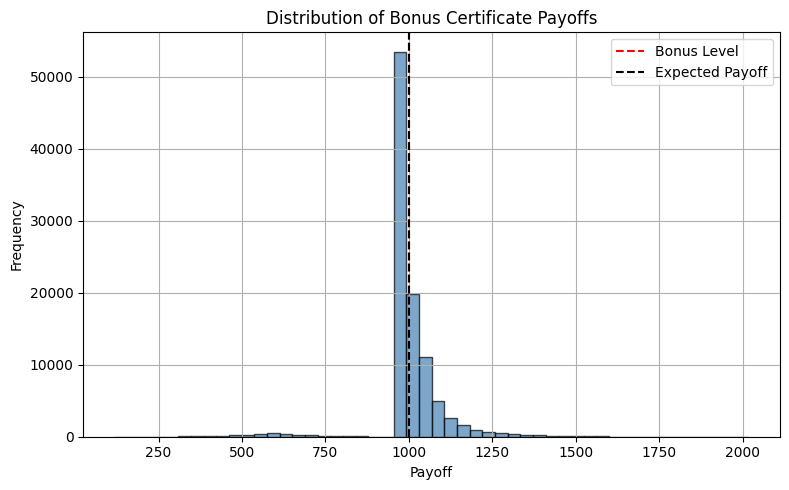

In [ ]:
# Histogram

plt.figure(figsize=(8, 5))
plt.hist(payoffs, bins=50, color="steelblue", edgecolor="black", alpha=0.7)
plt.axvline(x=1000, color="red", linestyle="--", label="Bonus Level")
plt.axvline(x=payoffs.mean(), color="black", linestyle="--", label="Expected Payoff")
plt.title("Distribution of Bonus Certificate Payoffs")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
os.makedirs("../assets", exist_ok=True)
filename = f"../assets/bc_histogram.png"
plt.savefig(filename)
plt.show()

In [40]:
import math

sell_price_raw = discounted_price * 1.02
sell_price = math.ceil(sell_price_raw / 5) * 5  # rounded up
cost_price = discounted_price
margin = sell_price - cost_price

print("Sell Price:", sell_price)
print("Cost Price (Model):", cost_price)
print(f"Bank's expected margin: {margin:.2f} USD")

Sell Price: 1015
Cost Price (Model): 991.441359031314
Bank's expected margin: 23.56 USD


## Hedging

### Delta-Hedging Strategy at Initiation (t = 0)

To hedge the Bonus Certificate's market exposure, we compute its **Delta** using central finite differences under the calibrated Bates model.

- **Delta at t = 0**: 0.6448  
- **Hedge position**: 676 shares (for a notional of \$1,000,000)

---

This implies the bank should **purchase 676 Costco shares** at inception to neutralize the product’s directional sensitivity.

- The hedge is **dynamic** — it requires rebalancing as the Delta evolves with time and path.
- It is **first-order only** — higher-order risks (gamma, vega, jump sensitivity) remain unhedged, motivating the **pricing margin**.

This hedge reduces the bank’s **P&L volatility** and cushions the impact of small spot movements shortly after issuance.

In [41]:
from exotic_price_and_hedge import HedgingStrategy

T = 0.25
bonus_level = 975
barrier_level = 600
pricer = MonteCarloExoticPricer(S0, r, T, v0, kappa, theta, sigma, rho, lamb, mu_j, sigma_j)

hedger = HedgingStrategy(
    pricer=pricer,   # calibrated MonteCarloExoticPricer
    B=bonus_level,
    H=barrier_level,
    T=T,
    notional=1_000_000
)

delta_0 = hedger.compute_delta()
shares = hedger.compute_hedge_position(delta_0)

print(f"Delta at t=0: {delta_0:.4f}")
print(f"Hedge position: {shares:.0f}")

Delta at t=0: 0.6448
Hedge position: 676
